# A/B Testing Comparing LLM Topic Modeling Techniques and Outputs/Results
* Notebook by Adam Lang
* Date: 1/31/2025

# Overview
* The purpose of this notebook is for data wrangling and taking a closer look at a raw data file that will be used for building a RAG application. This is a good example of how to A/B test or critically evaluate the data that will go into your RAG pipeline rather than just building it and evaluating it later. 
* The main purpose is to critically examine 2 methods that were used to extract "topics" and "keywords" from a PDF document using 2 different methods that involved LLMs. They were as follows:
    * 1) Claude-Haiku LLM using zero-shot prompting.
    * 2) BERTopic with Llama-3.1-8B-Instruct LLM with KeyBERT and MMR. 
* Thus the second half of this notebook is devoted to A/B testing/semantic analysis of the topics extracted using the Claude-Haiku LLM vs. topics extracted with BERTopic and Llama-3.1-8B-Instruct model. 

# Note about dataset
* The dataset is an open source PDF document freely available to the public from Moderna's website. It is not private or protected data. 
* The data is open source here: https://investors.modernatx.com/events-and-presentations/events/default.aspx

# TL;DR A/B Testing of Claude-Haiku Topics extracted vs. BERTopic-Llama-3.1 topics extracted
* Main findings: Claude performed a more "granular" topic and keyword extraction than the ladder method with BERTopic and Llama-3.1.

## A/B Testing Results Overview
1. Mann Whitney U test assessed distributions of HDBSCAN clusters comparing df1 vs. df2 topics. 
    * The p value was less than 0.05 suggesting that there is a meaningful difference between these 2 dataframe distributions in this specific cluster (cluster 3). 

2. Knowledge Graph/Network analysis
    * Revealed that the Claude topic modeling approach was more granular than the BERTopic-Llama-3 method which was more “higher level”. 

3. Cosine Similarity and Pairwise Comparison
    * Revealed that overall the cosine sim between the 2 topic datasets was 0.566.
    * The average pairwise similarity was: 0.195
    * The max similarity seen was 0.695.
    * We can say that there is at least a 50% similarity between the 2 datasets. 

4. Topic Modeling with Semantic Signal Separation Algorithm
    * df1 and df2 seem to have quite different topic distributions. 
    * df2 shows stronger topic associations (both positive and negative) compared to df1.
    * Topic 5 is particularly interesting as it's the most positively represented in df1 but the most negatively represented in df2, and this difference is statistically significant.
    * Topics 1, 7, and 8 are strongly positive in df2 but slightly negative in df1, suggesting these themes are much more prevalent in df2.
    * The negative weights in df2 (especially for Topics 4 and 5) suggest that these topics are strongly avoided or contrasted in df2 documents.
    * Interpretation:
        * T-statistic: Measures the difference between the two groups. A larger absolute value indicates a greater difference.
        * P-value: Indicates the probability that the observed difference could occur by chance. Generally, a p-value < 0.05 is considered statistically significant.

    * Looking closer at the results:
        * 1. Topic 5 shows a statistically significant difference (p-value = 0.02523649341692967 < 0.05). This suggests that Topic 5 is represented differently in df1 and df2, which aligns with the large difference in average weights we observed (-0.988256 in df2 vs 0.025083 in df1).
        * 2. Topic 8 is close to being statistically significant (p-value = 0.07503641125908107), suggesting a potential difference in representation between df1 and df2.
        * 3. All other topics have p-values > 0.05, indicating that there's not enough evidence to conclude that these topics are represented differently in df1 and df2.

    * To dive further into this A/B testing comparison of the topic modeling with Semantic Signal Separation the following was performed:
        * 1. Bar Plot
        * 2. Heat Map of Topic Weights
        * 3. Scatter Plot of Topic Weights
            * The topic weights were sparse for the Claude method and more dense for the BERTopic method. 
        4. Significance Plot
            * Overall the main finding was that 1 topic was different between the 2 datasets.


## Install dependencies

In [12]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Read in dataset - BERTopic with Llama-3.1-8B-Instruct Topics extracted

In [13]:
## read pickle file
df = pd.read_pickle('moderna_raw_19k.pkl')
df.head()

,rec_id,nom_id,award_id,ah_id,link_id,group_id,award_private,product_id,award_type,award_reason,title,message,award_date,value,remaining_value,freq
0,26062725,14400797,183277261,180514838,NaN,155298285,0,620,Stride,Collaborative,First IND writing support,"As I'm working on my first IND submission, I'm...",2024-12-30,35.0,0.0,1
2,17092356,26807710,182230718,180514685,NaN,154490006,0,620,Scale,Collaborative,Osmometer IOQ,Thank you for your demonstration of the new os...,2024-12-30,70.5,70.5,1
9,19243986,29376603,183172234,180514321,9565735.0,155223601,0,620,Scale,Collaborative,Great team work to support first PPQ at Harwell,The entire Manufacturing Team 2 demonstrated e...,2024-12-30,70.5,70.5,9
21,14400575,28676964,183302439,180514194,9577413.0,155315544,0,620,Salute,Collaborative,Dream Team,I want to express my gratitude for the unwaver...,2024-12-30,0.0,0.0,4
25,28382822,28751028,183298362,180514058,9576992.0,155313138,0,620,Stride,Collaborative,TEAM WORK AND WORK ETHIC,I want to thank everyone for their great teamw...,2024-12-30,30.5,0.0,4


## Exploratory Analysis

In [4]:
## check for missing values
df.isnull().sum()

rec_id                 0
nom_id                 0
award_id               0
ah_id                  0
link_id            13675
group_id               0
award_private          0
product_id             0
award_type             0
award_reason           0
title                  5
message                0
award_date             0
value                  0
remaining_value        0
freq                   0
dtype: int64

In [5]:
## info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19026 entries, 0 to 148693
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rec_id           19026 non-null  int64  
 1   nom_id           19026 non-null  int64  
 2   award_id         19026 non-null  int64  
 3   ah_id            19026 non-null  int64  
 4   link_id          5351 non-null   float64
 5   group_id         19026 non-null  int64  
 6   award_private    19026 non-null  int64  
 7   product_id       19026 non-null  int64  
 8   award_type       19026 non-null  object 
 9   award_reason     19026 non-null  object 
 10  title            19021 non-null  object 
 11  message          19026 non-null  object 
 12  award_date       19026 non-null  object 
 13  value            19026 non-null  float64
 14  remaining_value  19026 non-null  float64
 15  freq             19026 non-null  int64  
dtypes: float64(3), int64(8), object(5)
memory usage: 2.5+ MB


In [6]:
## number of messages
df['message'].count()

19026

In [7]:
df.columns

Index(['rec_id', 'nom_id', 'award_id', 'ah_id', 'link_id', 'group_id',
       'award_private', 'product_id', 'award_type', 'award_reason', 'title',
       'message', 'award_date', 'value', 'remaining_value', 'freq'],
      dtype='object')

In [8]:
## create new df
df_new = df[['award_type','award_reason','title','message','award_date']]
df_new.head()

,award_type,award_reason,title,message,award_date
0,Stride,Collaborative,First IND writing support,"As I'm working on my first IND submission, I'm...",2024-12-30
2,Scale,Collaborative,Osmometer IOQ,Thank you for your demonstration of the new os...,2024-12-30
9,Scale,Collaborative,Great team work to support first PPQ at Harwell,The entire Manufacturing Team 2 demonstrated e...,2024-12-30
21,Salute,Collaborative,Dream Team,I want to express my gratitude for the unwaver...,2024-12-30
25,Stride,Collaborative,TEAM WORK AND WORK ETHIC,I want to thank everyone for their great teamw...,2024-12-30


In [9]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19026 entries, 0 to 148693
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   award_type    19026 non-null  object
 1   award_reason  19026 non-null  object
 2   title         19021 non-null  object
 3   message       19026 non-null  object
 4   award_date    19026 non-null  object
dtypes: object(5)
memory usage: 891.8+ KB


## Convert pickle to csv file

In [10]:
## convert pickle to csv
df_new.to_csv('moderna_raw_19k.csv', index=False)

# Read in Claude-Haiku LLM topic modeling results

In [21]:
## read pickle
df_aws = pd.read_pickle('moderna_20k_pos_results.pkl')
df_aws.head()

,message,result,predict_claude,cost,stage2_prompt,stage2_result,topic_detected,key_match
86,"Melanie, Thank you for jumping in the RSV boat...","{'id': 'msg_bdrk_01A9Rnkh7cpiVhE2eDD8nAkT', 't...",yes,0.002139,\nAnalyze the following recognition message an...,topics_detected=True topics=['2'] key_match='RSV',True,RSV
109,Thanks to everyone from the Pilot team who hel...,"{'id': 'msg_bdrk_01X6Xb6preRLKSDPwfxo5Pc6', 't...",yes,0.002379,\nAnalyze the following recognition message an...,topics_detected=True topics=['4'] key_match='m...,True,mRNA-1083
226,Congrats on the 1st Federal mRESVIA order at W...,"{'id': 'msg_bdrk_011Zn3JzfnFQuBqS9KSCY67N', 't...",yes,0.001785,\nAnalyze the following recognition message an...,topics_detected=True topics=['2'] key_match='m...,True,mRESVIA
255,Congratulations on being our January CDO Star ...,"{'id': 'msg_bdrk_01DsL1NQrr9obthJW7cTP1JZ', 't...",yes,0.002985,\nAnalyze the following recognition message an...,topics_detected=True topics=['2'] key_match='P...,True,Phase 3 enrollment
310,Thank you mRNA-1083 tiger team for all your ha...,"{'id': 'msg_bdrk_01RzghJd5BnEcChYNvj1NCTS', 't...",yes,0.002535,\nAnalyze the following recognition message an...,topics_detected=True topics=['4'] key_match='m...,True,mRNA-1083


In [31]:
## get unique value counts of key_match column
df_aws['key_match'].value_counts().nunique()

13

Summary
* There are 13 unique classes in the key_match column.

In [40]:
## get the unique key_match values
## store in list
key_match = []
for i,j in enumerate(df_aws['key_match'].unique()):
    key_match.append(j)
    print(j)

RSV
mRNA-1083
mRESVIA
Phase 3 enrollment
mRNA-1283, RSV
none
SPIKEVAX
mRNA-1283, mRNA-1083, Ph3 studies, BLA
COVID-19 vaccine, 12.5 million doses
doses
1010-P303, 1083-P101
mResvia
RSV tenders
RSV, mRNA-1345
mRNA-1283
1083
covid vaccine,marketing campaigns,market channels
XBB MDV, m-RNA vaccin, Q4 revenue
Spikevax
COVID-19, immunization rates
RSV ACIP Working Group
RSV vaccine
mRNA-1283 BLA/MAA
mRNA-1345, Respiratory Syncytial Virus, Adults 60 Years and Older
SpikeVax
COVID VRBPAC
Spikevax JN.1, RSV, contracting, wholesalers, distribute
mRNA-1283 Ph3 IND
m-RNA-1010-P301 STUDY
Commercialization
mRESVIA New Drug Submission (NDS) approval in Canada
mRNA-1010
RSV program
1283
1083, 1283, 18-59
mRNA-1283, mRNA-1083
MRNA pipeline, future vaccines, combos
mRNA-1273, mRNA-1083
18 to 59 years old indication for mRNA-1345
mRNA-1083, Phase 3
mRNA-1273
mRNA-1283 MAA
new variant vaccine
upgraded vaccines
RSV marketing website
RSV filing
SPIKEVAX, COVID-19 vaccination, marketing
Spikevax, COVID-19 v

In [42]:
## key_match values
len(key_match)

197

In [44]:
pd.DataFrame(key_match).to_csv('key_match.csv', index=False)

# Data Science Comparison of the 2 Topic Modeling Results

* These are methods to compare the 2 topic modeling techniques and outputs/results. 

1. Embeddings, dimensionality reduction, and clustering
    * This is a solid approach for visualizing similarities and differences between the datasets.
    * It allows us to see how terms from both files relate to each other in a lower-dimensional space.

2. Knowledge graph
    * This can be useful for understanding relationships between terms, especially if you have structured data or want to explore connections between concepts.

3. Cosine similarity
    * This is a straightforward method to compare the similarity of terms between the two datasets.

4. Topic modeling with another algorithm. 
    * We could use LDA (Latent Dirilecht Allocation) but it has a few issues:
        * LDA works off the premise that documents with the same topic will have a lot of words in common.
        * LDA is a **bag of words model* meaning that it only considers individual tokens and not their relationships in a sentence.



## 1. Embeddings, Dimensionality Reduction and Clustering

In [52]:
%%capture
!pip install umap-learn hdbscan plotly

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [60]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer ## embeddings
import umap ## dimensionality reduction
import hdbscan ## dense clustering
#import matplotlib.pyplot as plt
#%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats

# Load both csv files
df1 = pd.read_csv('key_match.csv')
df2 = pd.read_csv('Moderna_Topics.csv')


In [61]:
## df1 head
df1.head()

,Topic_Keys
0,RSV
1,mRNA-1083
2,mRESVIA
3,Phase 3 enrollment
4,"mRNA-1283, RSV"


In [62]:
## df2 head
df2.head()

,CustomName,Representation,KeyBERT,Llama3,MMR,Representative_Docs
0,Biotech company quarterly earnings report,and billion amp sales stéphane net bancel ceo ...,cfo financials earnings ceo 3q revenue 2023 20...,Biotech company quarterly earnings report ...,billion amp stéphane bancel ceo 3q24 2024 30 e...,3Q24 earnings call agenda\nBusiness Review Sté...
1,Medical research and development of mRNA vaccines,mrna 000 phase study to 1010 vaccine nsclc wit...,mrna vaccine preclinical vaccination fda vacci...,Medical research and development of mRNA vacci...,phase 1010 nsclc efficacy voucher fluarix 4157...,Respiratory vaccines\nNext-gen COVID\nmRNA-128...
2,COVID-19 Vaccination Rates in the US,2023 and iqvia in for retail the encompasses t...,cdc vaccination pharmacies vaccines retail pre...,COVID-19 Vaccination Rates in the US,2023 and iqvia retail aug idn va audit cdc cha...,Based on information licensed from IQVIA: IQVI...
3,Forward-looking statements in corporate finance,sec forward statements looking these the and o...,statements disclaims securities future uncerta...,Forward-looking statements in corporate financ...,sec forward which moderna uncertainties factor...,". These risks, uncertainties, and other factor..."
4,Moderna's Respiratory Vaccine Business Update,moderna rsv of 2024 to in and regarding for mr...,pharma moderna 2024 pharmaceuticals rsv 2025 2...,Moderna's Respiratory Vaccine Business Update ...,moderna rsv 2024 mresvia sales years label abi...,RSV commercial update\n2024/2025 season\nOppor...


In [63]:
## drop 'Llama3' column
df2.drop('Llama3', axis=1, inplace=True)
df2.head()

,CustomName,Representation,KeyBERT,MMR,Representative_Docs
0,Biotech company quarterly earnings report,and billion amp sales stéphane net bancel ceo ...,cfo financials earnings ceo 3q revenue 2023 20...,billion amp stéphane bancel ceo 3q24 2024 30 e...,3Q24 earnings call agenda\nBusiness Review Sté...
1,Medical research and development of mRNA vaccines,mrna 000 phase study to 1010 vaccine nsclc wit...,mrna vaccine preclinical vaccination fda vacci...,phase 1010 nsclc efficacy voucher fluarix 4157...,Respiratory vaccines\nNext-gen COVID\nmRNA-128...
2,COVID-19 Vaccination Rates in the US,2023 and iqvia in for retail the encompasses t...,cdc vaccination pharmacies vaccines retail pre...,2023 and iqvia retail aug idn va audit cdc cha...,Based on information licensed from IQVIA: IQVI...
3,Forward-looking statements in corporate finance,sec forward statements looking these the and o...,statements disclaims securities future uncerta...,sec forward which moderna uncertainties factor...,". These risks, uncertainties, and other factor..."
4,Moderna's Respiratory Vaccine Business Update,moderna rsv of 2024 to in and regarding for mr...,pharma moderna 2024 pharmaceuticals rsv 2025 2...,moderna rsv 2024 mresvia sales years label abi...,RSV commercial update\n2024/2025 season\nOppor...


## Implementing Embeddings --> Dimensionality Reduction --> Clustering
* I will be using the Manhattan distance instead of Euclidean distance as it can produce better results, especially when dealing with sparse high-dimensional data or when outliers are present. 
* Also, it's often preferred in text classification and document clustering due to its effectiveness with sparse vector spaces. 
* The Manhattan distance's lower sensitivity to extreme values in individual dimensions can lead to more balanced clustering results in certain datasets.
* While there is a specific way to tune the parameters of an HDBSCAN model, we don't need to do that here.


In [67]:

# Combine all text data
df1_text = list(df1['Topic_Keys'])
df2_text = list(df2['CustomName']) + list(df2['Representation']) + list(df2['KeyBERT']) + list(df2['MMR'])
all_text = df1_text + df2_text

# Create embeddings
model = SentenceTransformer('all-MiniLM-L6-v2') ## general embedding model to use 
embeddings = model.encode(all_text)

# Reduce dimensionality
reducer = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
umap_embeddings = reducer.fit_transform(embeddings)

# Cluster
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='manhattan', cluster_selection_method='eom')
cluster_labels = clusterer.fit_predict(umap_embeddings)

# # Code to visualize clusters if using matplotlib
# plt.figure(figsize=(12, 8))
# plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, cmap='rainbow')
# plt.title('HDBSCAN clustering of Both Topic data', fontsize=18)
# plt.colorbar()
# plt.legend()
# plt.show();

## Plotting clusters using Plotly interactive
# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'x': umap_embeddings[:, 0],
    'y': umap_embeddings[:, 1],
    'cluster': cluster_labels,
    'text': all_text,
    'source': ['df1'] * len(df1_text) + ['df2'] * len(df2_text)
})

# Create an interactive plot with plotly
fig = px.scatter(
    plot_df, 
    x='x', 
    y='y', 
    color='cluster', 
    symbol='source',
    hover_data=['text'],
    title='HDBSCAN Clustering Comparison of Topic Data for Moderna',
    color_continuous_scale=px.colors.qualitative.Dark24,
    
)

# Move the 'source' legend to the right side
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Summary
* What we can see is that clusters 2, 3, and 4 (the 3 clusters in the middle of the plot) are where df1 and df2 overlap with similarities. 
* The 1st cluster (light blue) and 5th cluster (brown) are only seen in df1 and are considered outliers compared to the 3 middle clusters.

In [69]:
# Calculate cluster distances
cluster_centers = plot_df.groupby('cluster')[['x', 'y']].mean()
distances = pd.DataFrame(index=cluster_centers.index, columns=cluster_centers.index)

for i in cluster_centers.index:
    for j in cluster_centers.index:
        if i != j:
            # Using Euclidean distance
            distances.loc[i, j] = np.linalg.norm(cluster_centers.loc[i] - cluster_centers.loc[j])

print("Cluster Distances:")
print(distances)

# Analyze significance of differences between df1 and df2
def analyze_cluster_differences(df):
    results = []
    for cluster in df['cluster'].unique():
        if cluster != -1:  # Exclude noise points (cluster -1)
            df1_cluster = df[(df['source'] == 'df1') & (df['cluster'] == cluster)]
            df2_cluster = df[(df['source'] == 'df2') & (df['cluster'] == cluster)]
            
            if len(df1_cluster) > 0 and len(df2_cluster) > 0:
                _, p_value = stats.mannwhitneyu(
                    df1_cluster[['x', 'y']].values.flatten(),
                    df2_cluster[['x', 'y']].values.flatten()
                )
                results.append({
                    'cluster': cluster,
                    'df1_count': len(df1_cluster),
                    'df2_count': len(df2_cluster),
                    'p_value': p_value
                })
    
    return pd.DataFrame(results)

difference_analysis = analyze_cluster_differences(plot_df)
print("\nCluster Difference Analysis:")
print(difference_analysis)

# Visualize the differences
fig_diff = go.Figure()

for source in ['df1', 'df2']:
    fig_diff.add_trace(go.Bar(
        x=difference_analysis['cluster'],
        y=difference_analysis[f'{source}_count'],
        name=source,
        marker_color='blue' if source == 'df1' else 'red'
    ))

fig_diff.update_layout(
    title='Cluster Composition: df1 vs df2',
    xaxis_title='Cluster',
    yaxis_title='Count',
    barmode='group',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Add p-values as annotations
for _, row in difference_analysis.iterrows():
    fig_diff.add_annotation(
        x=row['cluster'],
        y=max(row['df1_count'], row['df2_count']),
        text=f"p={row['p_value']:.3f}",
        showarrow=False,
        yshift=10
    )

fig_diff.show()

Cluster Distances:
cluster         0         1         2         3         4
cluster                                                  
0             NaN  9.851599  6.316825  4.504761  7.158436
1        9.851599       NaN  4.367004  6.596944  4.572535
2        6.316825  4.367004       NaN  5.048922  5.121634
3        4.504761  6.596944  5.048922       NaN   2.77799
4        7.158436  4.572535  5.121634   2.77799       NaN

Cluster Difference Analysis:
   cluster  df1_count  df2_count   p_value
0        4         33          2  0.191686
1        3         33         10  0.000018
2        2         75          8  0.317991


### Summary of Clustering Comparison
* To analyze the significance of differences between df1 and df2:
    * The function `analyze_cluster_differences` performs a Mann-Whitney U test for each cluster, comparing the distributions of df1 and df2 points within that cluster.
* The results are stored in a DataFrame, showing the count of points from each source and the p-value for each cluster.
* There is a Plotly plot to visualize these differences. It shows:
    1. A grouped bar chart comparing the count of df1 and df2 points in each cluster.
    2. The p-value for each cluster is annotated above the bars.
    3. This additional analysis and visualization will helps us understand:
        * Which clusters have a significant difference in composition between df1 and df2 (e.g. look for low p-values, typically < 0.05).
        * The relative proportion of df1 and df2 points in each cluster.
        * Remember that the **Mann-Whitney U test** is assessing whether the distributions of points from df1 and df2 within each cluster are significantly different. 
        * **A low p-value suggests that the points from df1 and df2 in that cluster come from different distributions, indicating a meaningful difference between the two datasets in that cluster.**



* Note about the discrepancy in the number of clusters in HDBSCAN plot vs. the comparison plot above:

1. HDBSCAN can assign some points as noise (cluster label -1).
2. In the `analyze_cluster_differences` function, we've added a condition to exclude noise points (cluster -1) from the analysis.
3. We only perform the Mann-Whitney U test for clusters that have points from **both df1 and df2.**


## 2. Knowledge Graph Comparision

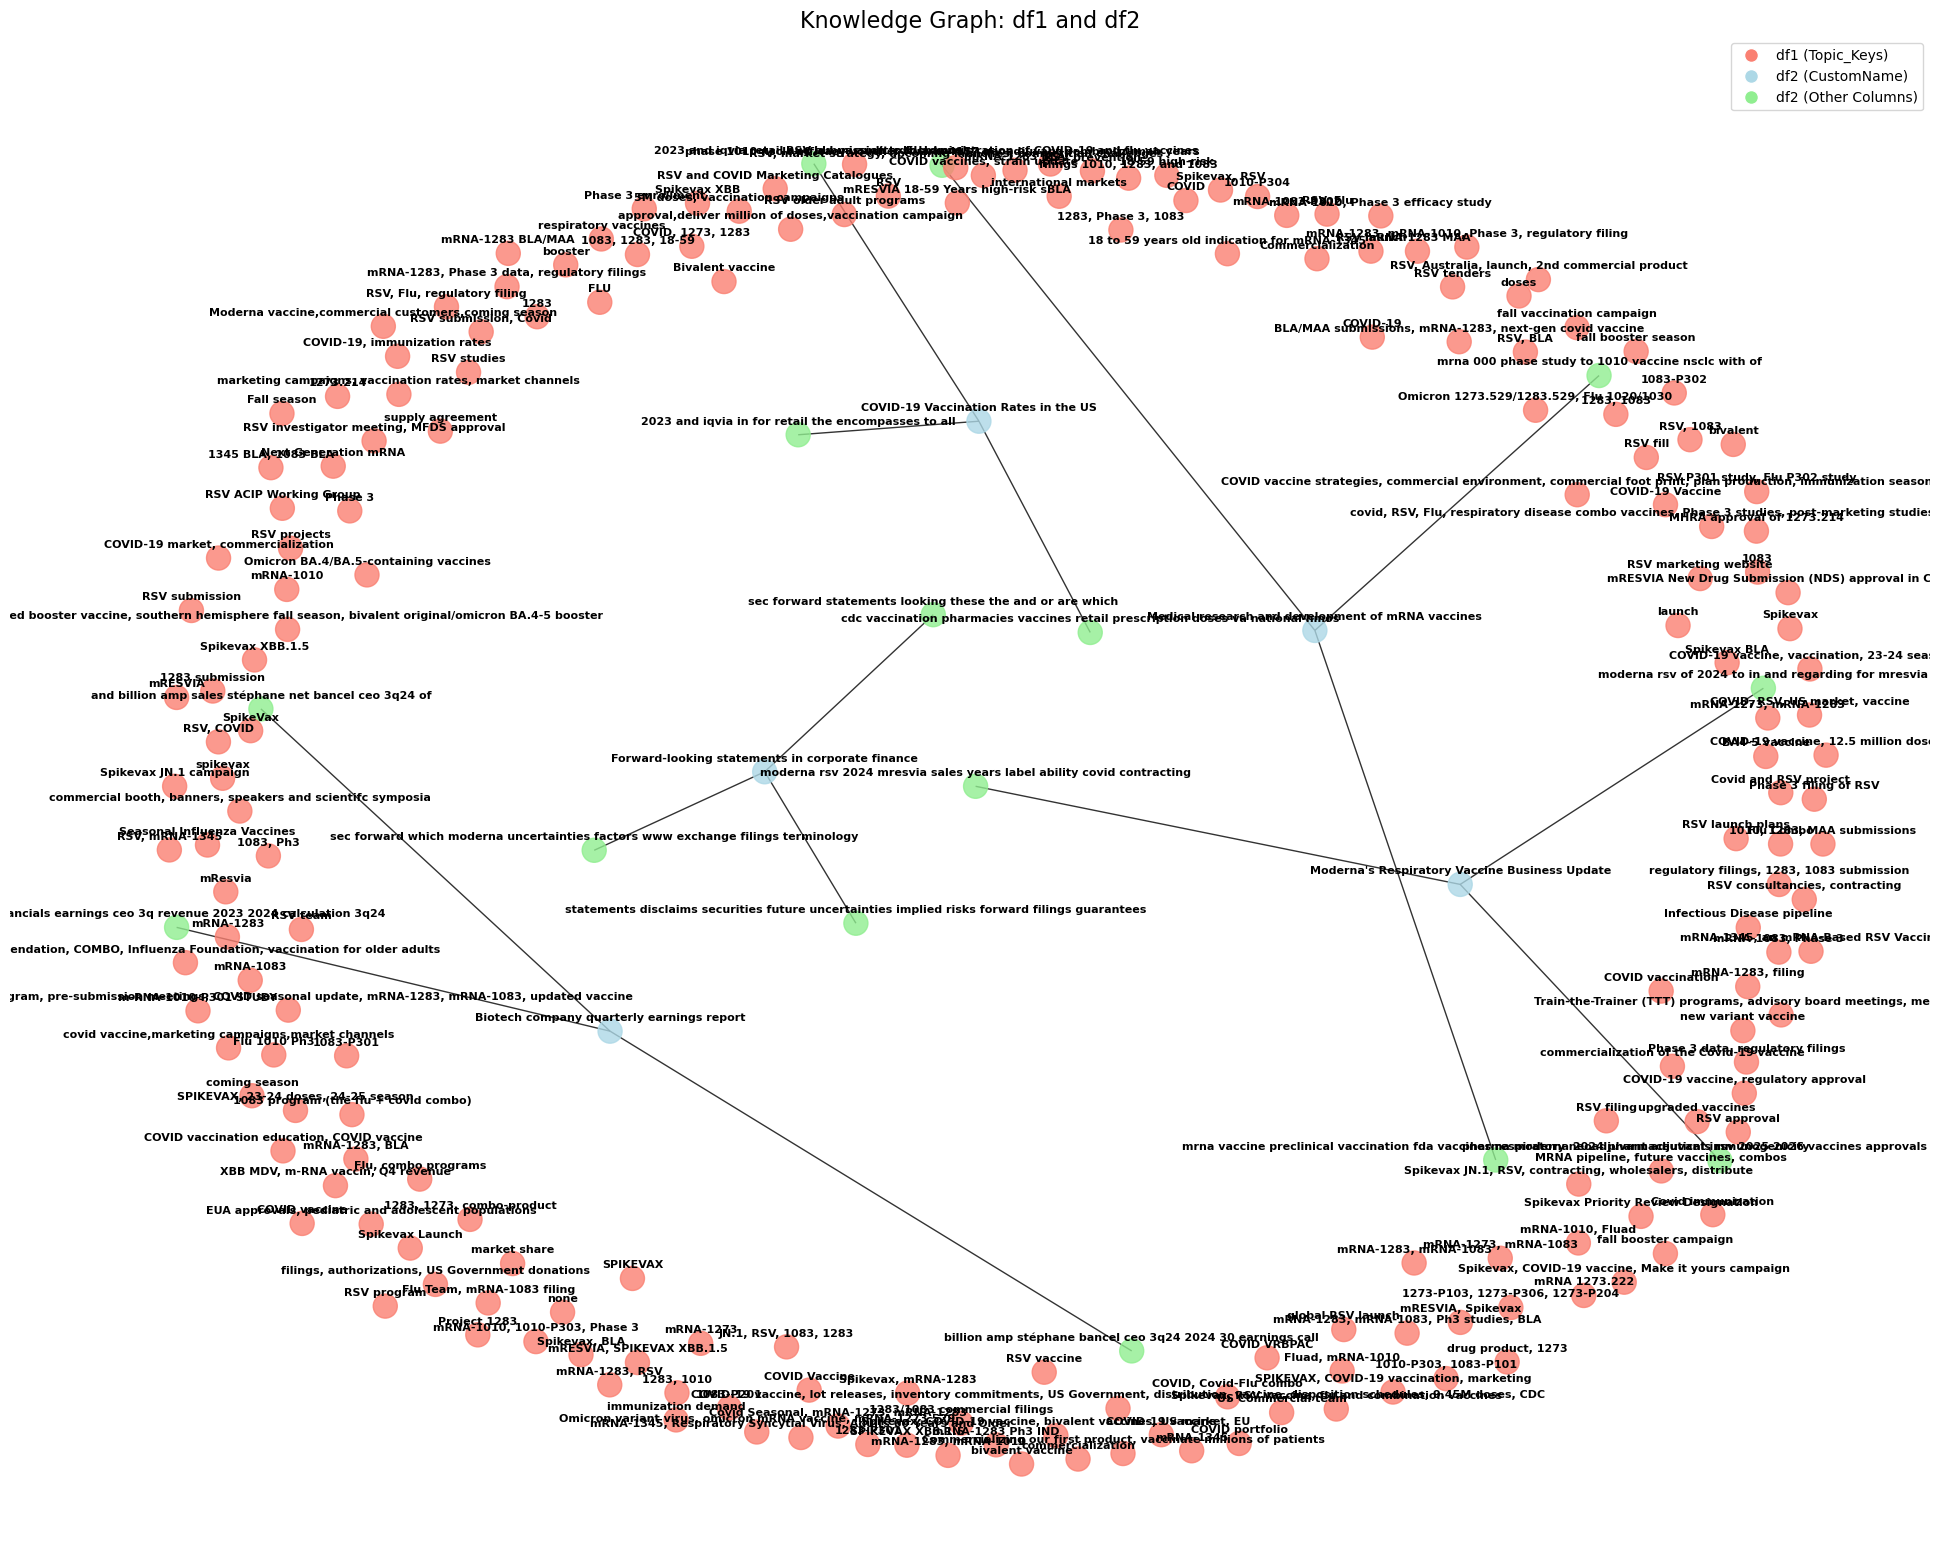

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


# Create a network graph
G = nx.Graph()

# Add nodes and edges based on df2 data
for index, row in df2.iterrows():
    G.add_node(row['CustomName'], color='lightblue', source='df2_custom')
    G.add_node(row['Representation'], color='lightgreen', source='df2_other')
    G.add_node(row['KeyBERT'], color='lightgreen', source='df2_other')
    G.add_node(row['MMR'], color='lightgreen', source='df2_other')
    G.add_edge(row['CustomName'], row['Representation'])
    G.add_edge(row['CustomName'], row['KeyBERT'])
    G.add_edge(row['CustomName'], row['MMR'])

# Add nodes from df1
for topic in df1['Topic_Keys']:
    G.add_node(topic, color='salmon', source='df1')

# Get position layout
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Set up the figure
plt.figure(figsize=(20, 16))
ax = plt.gca()
ax.set_position([0.1, 0.1, 0.8, 0.8])  # Adjust the position of the plot within the figure

# Draw the graph
nx.draw(G, pos, 
        node_color=[G.nodes[n]['color'] for n in G.nodes],
        with_labels=False, 
        node_size=300, 
        alpha=0.8,
        ax=ax)

# Add labels with adjusted positions
label_pos = {k: (v[0], v[1]+0.02) for k, v in pos.items()}  # Slightly adjust label positions
nx.draw_networkx_labels(G, label_pos, font_size=8, font_weight="bold", ax=ax)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='df1 (Topic_Keys)',
                              markerfacecolor='salmon', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='df2 (CustomName)',
                              markerfacecolor='lightblue', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='df2 (Other Columns)',
                              markerfacecolor='lightgreen', markersize=10)]
ax.legend(handles=legend_elements, loc='upper right')

plt.title("Knowledge Graph: df1 and df2", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

### Summary of Network/Knowledge Graph
* We see that we see the green which is the BERTopic-Llama3.1 LLM topics and the red/salmon color which is df1 which is Claude-Haiku LLMs topics. 
* The main takeaway here is that the topics extracted from BERTopic-Llama-3.1 (green-df2) are "higher level" whereas Claude-Haiku's topics (red-df1) are more granular and they are overall all semantically related. 

## 3. Cosine Similarity Comparison

In [79]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Combine all text from both dfs
df1_text = ' '.join(df1['Topic_Keys'])
df2_text = ' '.join(df2['CustomName'] + ' ' + df2['Representation'] + ' ' + df2['KeyBERT'] + ' ' + df2['MMR'])

# Create embeddings
df1_embedding = model.encode([df1_text])
df2_embedding = model.encode([df2_text])

# Calculate cosine similarity
similarity = cosine_similarity(df1_embedding, df2_embedding)[0][0]
print(f"Cosine similarity between the two datasets: {similarity}")

# If you want to calculate similarities between individual entries
df1_embeddings = model.encode(df1['Topic_Keys'].tolist())
df2_embeddings = model.encode((df2['CustomName'] + ' ' + df2['Representation'] + ' ' + df2['KeyBERT'] + ' ' + df2['MMR']).tolist())

# Calculate pairwise similarities
pairwise_similarities = cosine_similarity(df1_embeddings, df2_embeddings)

# Print average similarity
average_similarity = np.mean(pairwise_similarities)
print(f"Average pairwise similarity between entries: {average_similarity}")

# If you want to find the most similar pairs
max_similarity = np.max(pairwise_similarities)
max_indices = np.unravel_index(np.argmax(pairwise_similarities), pairwise_similarities.shape)

print(f"Maximum similarity: {max_similarity}")
print(f"Most similar pair:")
print(f"  df1 entry: {df1['Topic_Keys'].iloc[max_indices[0]]}")
print(f"  df2 entry: {df2['CustomName'].iloc[max_indices[1]]}")

Cosine similarity between the two datasets: 0.5663347244262695
Average pairwise similarity between entries: 0.1958053708076477
Maximum similarity: 0.6949160695075989
Most similar pair:
  df1 entry: COVID-19 vaccine, lot releases, inventory commitments, US Government, distribution, vaccine, disposition schedules, 9.45M doses, CDC
  df2 entry: COVID-19 Vaccination Rates in the US


## 4. Topic Modeling using Semantic Signal Separation
* I will use this algorithm from the TurfTopic library: https://github.com/x-tabdeveloping/turftopic/blob/main/docs/s3.md
* The original paper: https://arxiv.org/html/2406.09556v1
* Excellent blog post on this method: https://medium.com/towards-data-science/semantic-signal-separation-769f43b46779#1acb-a1ec08a141a8
* Reasoning
    * Topic models are useful tools for discovering latent semantic structures in large textual corpora. 
    * Topic modeling used to solely rely on bag-of-words representations of language. This approach makes models sensitive to the presence of stop words and noise, and does not utilize potentially useful contextual information. 
    * Recent efforts have been oriented at incorporating contextual neural representations in topic modeling and have been shown to outperform classical topic models. 
    * These approaches are, however, typically slow, volatile and still require preprocessing for optimal results. 
    * The authors of the paper above introduced `Semantic Signal Separation (S3)`, a theory-driven topic modeling approach in neural embedding spaces. 
        * S3 conceptualizes topics as independent axes of semantic space, and uncovers these with blind-source separation. 
        * The algorithm they are using is the ICA or independent component analysis algorithm from sklearn which is another algo used for dimensionality reduction most commonly used in audio or visual data or most popular with the "cocktail party problem" of separating audio signals in a vector space. 
        * Their approach provides the most diverse, highly coherent topics, requires no preprocessing, and is demonstrated to be the fastest contextually sensitive topic model to date. 

In [83]:
%%capture 
!pip install turftopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [88]:
import pandas as pd
import numpy as np
from turftopic import SemanticSignalSeparation
import plotly.express as px
from scipy import stats


# Prepare the data
df1_docs = df1['Topic_Keys'].tolist()
df2_docs = (df2['CustomName'] + ' ' + df2['Representation'] + ' ' + df2['KeyBERT'] + ' ' + df2['MMR']).tolist()
all_docs = df1_docs + df2_docs

# Initialize and fit the SemanticSignalSeparation model
n_topics = 10
model = SemanticSignalSeparation(n_topics, encoder="all-MiniLM-L12-v2")
model.fit(all_docs)

# Print topics
print("Topics for all documents:")
model.print_topics()

# Extract vocabulary and select words to display
vocab = model.get_vocab()
document_term_matrix = model.vectorizer.transform(all_docs)
frequencies = document_term_matrix.sum(axis=0)
frequencies = np.squeeze(np.asarray(frequencies))

# Select the 99th percentile
selected_terms_mask = frequencies > np.quantile(frequencies, 0.99)
selected_terms = np.array(vocab)[selected_terms_mask]

# Create DataFrame with selected dimensions and terms
terms_with_axes = pd.DataFrame({
    "topic1": model.components_[0][selected_terms_mask],
    "topic2": model.components_[1][selected_terms_mask],
    "topic3": model.components_[2][selected_terms_mask],
    "term": selected_terms
})

# Create scatter plot
fig = px.scatter(
    terms_with_axes,
    text="term",
    x="topic1",
    y="topic2",
    color="topic3",
    template="plotly_white",
    color_continuous_scale="Bluered",
)

fig.update_layout(
    width=1200,
    height=800,
    title="Topic Comparison: All Documents"
)

fig.update_traces(
    textposition="top center",
    marker=dict(size=12, line=dict(width=2, color="white"))
)

fig.show()

# Compare df1 and df2
def get_document_topic_weights(docs):
    return model.transform(docs)

df1_weights = get_document_topic_weights(df1_docs)
df2_weights = get_document_topic_weights(df2_docs)

# Create DataFrames for df1 and df2 topic weights
df1_topic_weights = pd.DataFrame(df1_weights, columns=[f"Topic_{i}" for i in range(n_topics)])
df2_topic_weights = pd.DataFrame(df2_weights, columns=[f"Topic_{i}" for i in range(n_topics)])

# Add source columns
df1_topic_weights['source'] = 'df1'
df2_topic_weights['source'] = 'df2'

# Combine df1 and df2 topic weights
combined_topic_weights = pd.concat([df1_topic_weights, df2_topic_weights], ignore_index=True)

# Create scatter plot to compare df1 and df2
fig_comparison = px.scatter(
    combined_topic_weights,
    x="Topic_0",
    y="Topic_1",
    color="source",
    symbol="source",
    template="plotly_white",
)

fig_comparison.update_layout(
    width=1200,
    height=800,
    title="Topic Comparison: df1 vs df2"
)

fig_comparison.show()

# Print average topic weights for df1 and df2
print("\nAverage topic weights for df1:")
print(df1_topic_weights.drop('source', axis=1).mean())

print("\nAverage topic weights for df2:")
print(df2_topic_weights.drop('source', axis=1).mean())

# Perform t-test to compare topic weights between df1 and df2
for topic in range(n_topics):
    t_stat, p_value = stats.ttest_ind(df1_topic_weights[f"Topic_{topic}"], df2_topic_weights[f"Topic_{topic}"])
    print(f"\nTopic {topic}:")
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")


/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Output()

[13:28:43] Documents encoded.                                                                         ]8;id=259309;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=719093;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py#130\130]8;;\

/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning:

FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.

           Decomposition done.                                                                        ]8;id=550029;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=546131;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py#133\133]8;;\

           Term extraction done.                                                                      ]8;id=248815;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=478354;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py#136\136]8;;\

           Vocabulary encoded.                                                                        ]8;id=827180;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=189609;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py#146\146]8;;\

           Model fitting done.                                                                        ]8;id=152367;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py\decomp.py]8;;\:]8;id=833938;file:///opt/anaconda3/lib/python3.12/site-packages/turftopic/models/decomp.py#159\159]8;;\

Topics for all documents:


┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Topic ID ┃ Highest Ranking                            ┃ Lowest Ranking                              ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        0 │ 1273, 1283, flu, vaccines, vaccine         │ spikevax, 19, covid, mrna, rsv              │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        1 │ mrna, 1010, covid, phase, vaccines         │ 1283, 1083, 1273, 19, rsv                   │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        2 │ 1283, 1273, 1083, 19, vaccine              │ flu, phase, covid, mrna, vaccines           │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        3 │ 1010, rsv, 1273, 1283, 1083                │ covid, vaccine, vaccination, vaccines, mrna │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        4 │ phase, 19, 1083, mrna, covid               │ 1273, 1010, rsv, spikevax, 1283             │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        5 │ covid, flu, 1273, 1283, mrna               │ vaccination, vaccine, vaccines, 1010, 19    │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        6 │ 1083, 1010, phase, 1283, 19                │ mrna, covid, flu, spikevax, vaccination     │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        7 │ 1083, 1273, 1283, 1010, 19                 │ mrna, rsv, vaccine, spikevax, vaccines      │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        8 │ phase, mrna, flu, spikevax, 19             │ 1283, 1273, 1083, vaccine, vaccines         │
├──────────┼────────────────────────────────────────────┼─────────────────────────────────────────────┤
│        9 │ rsv, vaccine, vaccination, vaccines, covid │ mrna, 1273, 1283, 19, 1010                  │
└──────────┴────────────────────────────────────────────┴─────────────────────────────────────────────┘


Average topic weights for df1:
Topic_0   -0.006067
Topic_1   -0.013409
Topic_2   -0.002103
Topic_3   -0.000202
Topic_4    0.016617
Topic_5    0.025083
Topic_6    0.003810
Topic_7   -0.012247
Topic_8   -0.020000
Topic_9   -0.000699
dtype: float32

Average topic weights for df2:
Topic_0    0.239032
Topic_1    0.528309
Topic_2    0.082840
Topic_3    0.007944
Topic_4   -0.654732
Topic_5   -0.988256
Topic_6   -0.150131
Topic_7    0.482519
Topic_8    0.788010
Topic_9    0.027527
dtype: float32

Topic 0:
T-statistic: -0.5389367615570995
P-value: 0.5905298798125465

Topic 1:
T-statistic: -1.194534746115458
P-value: 0.2336835690449274

Topic 2:
T-statistic: -0.1866560999667802
P-value: 0.8521194777980436

Topic 3:
T-statistic: -0.017897896227139675
P-value: 0.985738149510561

Topic 4:
T-statistic: 1.483221856467639
P-value: 0.139589582051138

Topic 5:
T-statistic: 2.2546899423903137
P-value: 0.02523649341692967

Topic 6:
T-statistic: 0.3383470985237607
P-value: 0.7354565518778946

Topic 7:
T-s

### Summary
1. Average Topic Weights: These represent the average strength or prevalence of each topic in df1 and df2.
    * For df1:
        * Most topics have small negative weights, with Topic_5 having the highest positive weight (0.025083).
        * This suggests that Topic_5 is the most prevalent in df1, while other topics are less represented or slightly negatively correlated.
    * For df2:
        * There's a much wider range of weights, from -0.988256 (Topic_5) to 0.788010 (Topic_8).
        * Topic_1, Topic_7, and Topic_8 have high positive weights, suggesting they are strongly represented in df2.
        * Topic_4 and Topic_5 have large negative weights, indicating a strong negative correlation with these topics in df2.

2. T-test Results: The t-test compares the topic weights between df1 and df2 for each topic. It helps determine if there's a statistically significant difference in how each topic is represented in the two datasets.

Interpretation:

    * T-statistic: Measures the difference between the two groups. A larger absolute value indicates a greater difference.
    * P-value: Indicates the probability that the observed difference could occur by chance. Generally, a p-value < 0.05 is considered statistically significant.

Looking closer at the results:

1. Topic 5 shows a statistically significant difference (p-value = 0.02523649341692967 < 0.05). This suggests that Topic 5 is represented differently in df1 and df2, which aligns with the large difference in average weights we observed (-0.988256 in df2 vs 0.025083 in df1).

2. Topic 8 is close to being statistically significant (p-value = 0.07503641125908107), suggesting a potential difference in representation between df1 and df2.

3. All other topics have p-values > 0.05, indicating that there's not enough evidence to conclude that these topics are represented differently in df1 and df2.

Overall interpretation:

* df1 and df2 seem to have quite different topic distributions. 
* df2 shows stronger topic associations (both positive and negative) compared to df1.
* Topic 5 is particularly interesting as it's the most positively represented in df1 but the most negatively represented in df2, and this difference is statistically significant.
* Topics 1, 7, and 8 are strongly positive in df2 but slightly negative in df1, suggesting these themes are much more prevalent in df2.
* The negative weights in df2 (especially for Topics 4 and 5) suggest that these topics are strongly avoided or contrasted in df2 documents.

# Visualizations of Comparing df1 vs df2 using Semantic Signal Separation

1. Bar Plot of Average Topic Weights
    * This will show the difference in topic weights between df1 and df2 side by side.
    * The average weight of each topic for df1 and df2 side by side. 
    * This allows for easy comparison of topic prevalence between the two datasets.


2. Heatmap of Topic Weights
    * This can provide a color-coded view of the topic weights for both datasets.
    * Detailed look at how individual documewnts are distributed. 

3. Scatter Plot of Topic Weights
    * This can show how documents from df1 and df2 are distributed across two selected topics.

4. Significance Plot
    * This can visualize the statistical significance of the differences between df1 and df2 for each topic.
    * Identify which topic differences are statistically meaningful.



## 1. Bar Plot Comparison

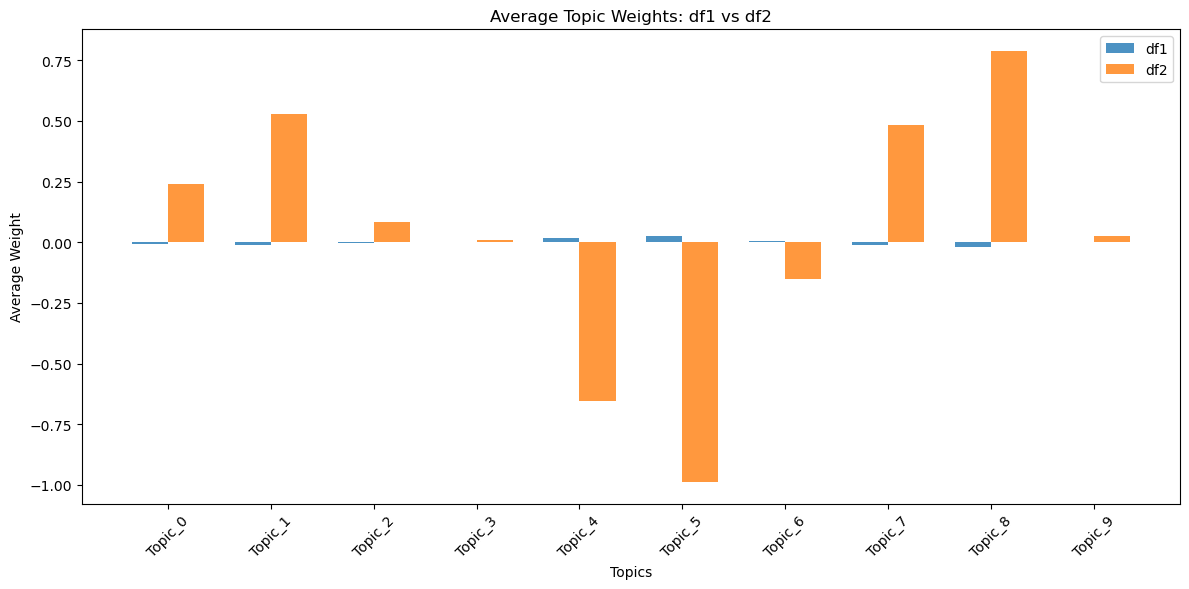

In [89]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Prepare data for plotting
topics = [f'Topic_{i}' for i in range(n_topics)]
df1_means = df1_topic_weights.drop('source', axis=1).mean()
df2_means = df2_topic_weights.drop('source', axis=1).mean()

# 1. Bar Plot of Average Topic Weights
plt.figure(figsize=(12, 6))
x = np.arange(len(topics))
width = 0.35
plt.bar(x - width/2, df1_means, width, label='df1', alpha=0.8)
plt.bar(x + width/2, df2_means, width, label='df2', alpha=0.8)
plt.xlabel('Topics')
plt.ylabel('Average Weight')
plt.title('Average Topic Weights: df1 vs df2')
plt.xticks(x, topics, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()





## 2. Heatmap of Topic Weights

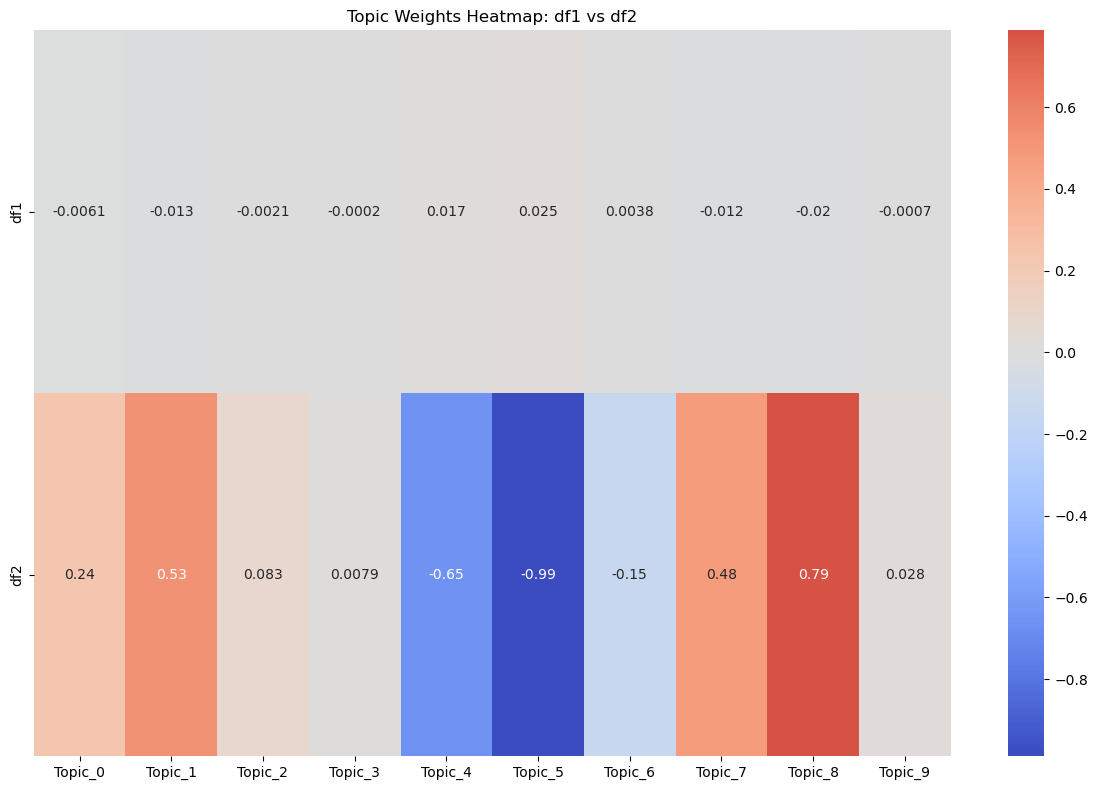

In [90]:
# 2. Heatmap of Topic Weights
plt.figure(figsize=(12, 8))
heatmap_data = pd.DataFrame({'df1': df1_means, 'df2': df2_means}).T
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0)
plt.title('Topic Weights Heatmap: df1 vs df2')
plt.tight_layout()
plt.show()

## 3. Scatter Plot of Topic Weights

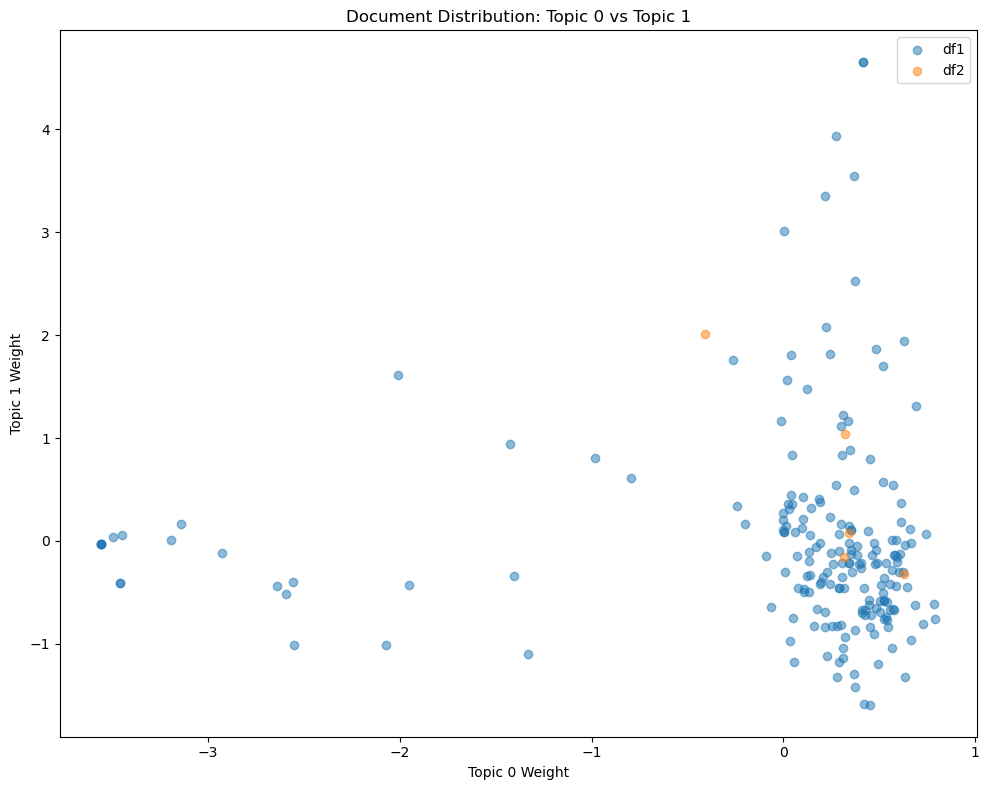

In [91]:
# 3. Scatter Plot of Topic Weights
plt.figure(figsize=(10, 8))
plt.scatter(df1_topic_weights['Topic_0'], df1_topic_weights['Topic_1'], alpha=0.5, label='df1')
plt.scatter(df2_topic_weights['Topic_0'], df2_topic_weights['Topic_1'], alpha=0.5, label='df2')
plt.xlabel('Topic 0 Weight')
plt.ylabel('Topic 1 Weight')
plt.title('Document Distribution: Topic 0 vs Topic 1')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Significance Plot

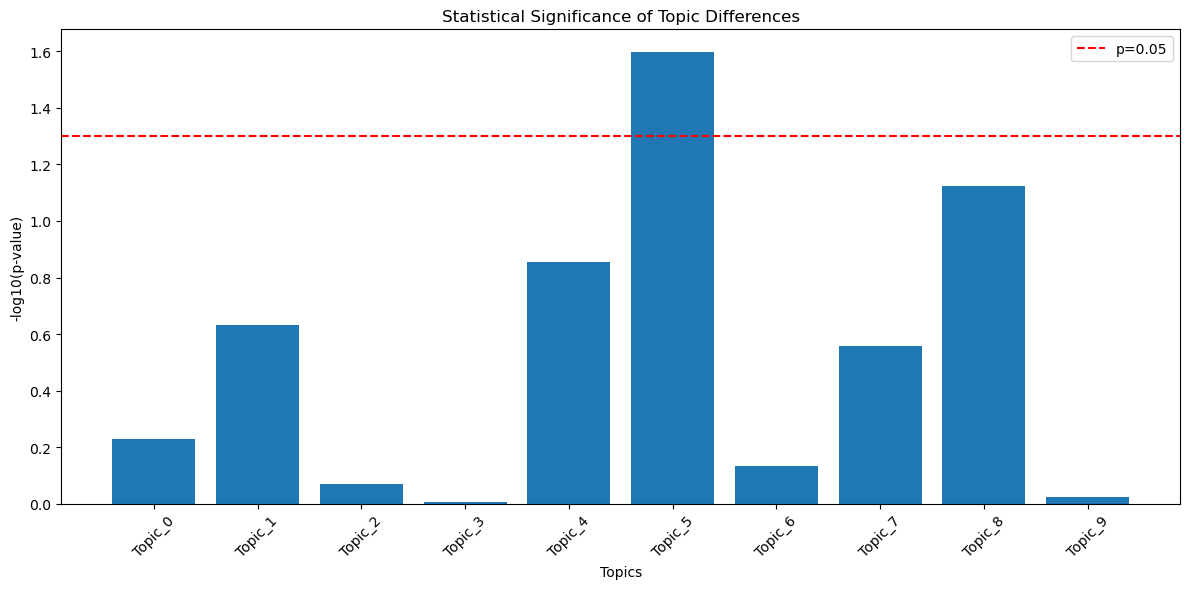

In [92]:
# 4. Significance Plot
plt.figure(figsize=(12, 6))
p_values = []
for topic in range(n_topics):
    _, p_value = stats.ttest_ind(df1_topic_weights[f'Topic_{topic}'], df2_topic_weights[f'Topic_{topic}'])
    p_values.append(p_value)

plt.bar(topics, -np.log10(p_values))
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.xlabel('Topics')
plt.ylabel('-log10(p-value)')
plt.title('Statistical Significance of Topic Differences')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Summary
* The red line above in the significance plot represents the threshold for statistical significance, typically set at p = 0.05.

* The red line is drawn at y = -log10(0.05) ≈ 1.30103.
    * In the plot, the y-axis represents -log10(p-value). We use this transformation because:
    * It makes small p-values (which are more significant) appear as taller bars.
    * It spreads out the range of p-values for better visualization.
    * The p = 0.05 threshold is commonly used in statistics to determine significance. A p-value less than 0.05 is often considered statistically significant.

On this plot:

* Bars that exceed the red line (i.e., are taller than the line) represent topics where the difference between df1 and df2 is statistically significant at the p < 0.05 level.
* Bars that don't reach the red line represent topics where the difference is not statistically significant at this level.

Interpreting the plot:

* Topics with bars higher than the red line: These show strong evidence of a difference between df1 and df2.
* Topics with bars just below the red line: These suggest a possible difference, but it's not strong enough to meet the conventional p < 0.05 threshold.
* Topics with very short bars: These indicate little to no evidence of a difference between df1 and df2.
* Remember, while p < 0.05 is a common threshold, it's somewhat arbitrary. In some contexts, you might use a different threshold (e.g., p < 0.01 for more stringent criteria, or p < 0.1 for more exploratory analyses). The red line helps visually identify which topics meet your chosen significance threshold.

Overall:
* The red line represents our threshold for statistical significance. Bars that exceed this line indicate topics where we have strong evidence of a difference between the two datasets. The taller the bar, the stronger the evidence of a difference.